Fuel Price Prediction
Objective
To build suitable Machine Learning Model for Fuel Price Prediction on the bellow data set.

Table of contents
Importing Libraries and Dataset
Exploratory Data Analysis
Feature Engineering
Data Vizualization
Model Building
Model Evaluation
Generating pickle


Importing Libraries and Dataset

In [45]:
# importing required libraries
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from lightgbm.sklearn import LGBMRegressor

Load the Perth fuel data from AWS Database.

    The dataset was taken from the fuelwatch web site starts from 2002 to current day. The columnes are listed below giving a view of the data we have to work with to create prediction on price. 
        
        column name = Description 
        year = Year of record 
        month = Month of record 
        day = Day of record 
        trading_name = Name of fuel station 
        brand_description = Brand of fuel station 
        product_description = Type of feul 
        product_price = Price recorderd 
        address = address of station (DROPPED)
        location = Location based on Suberb 
        postcode = Perth postcode (DROPPED)
        area_description = Area location in WA 
        region_description = Region location in WA 

In [46]:
# Load CSV 
perth_fuel = pd.read_csv("Resources\perthfuel.csv")
perth_fuel.head()

,Unnamed: 0,publish_date,trading_name,brand_description,product_description,product_price,address,location,postcode,area_description,region_description
0,0,01/01/2019,53 Mile Roadhouse,United,ULP,121.9,31 South Western Hwy,PINJARRA,6208,Murray,Peel
1,1,01/01/2019,53 Mile Roadhouse,United,Diesel,137.9,31 South Western Hwy,PINJARRA,6208,Murray,Peel
2,2,01/01/2019,53 Mile Roadhouse,United,98 RON,150.9,31 South Western Hwy,PINJARRA,6208,Murray,Peel
3,3,01/01/2019,7-Eleven Ascot,7-Eleven,ULP,139.9,194 Great Eastern Hwy,ASCOT,6104,South of River,Metro
4,4,01/01/2019,7-Eleven Ascot,7-Eleven,Brand Diesel,139.9,194 Great Eastern Hwy,ASCOT,6104,South of River,Metro


In [47]:
# Drop columns to reduce the diffrent featuere. 
perth_fuel = perth_fuel.drop(columns=[
    'Unnamed: 0',
    'address',
    'postcode',
    'area_description',
    'location',
    'trading_name',
    'brand_description']).reset_index().drop(columns=['index'])

In [48]:
# Get a idea of the size of the dataframe. 
print('The size of Dataframe is: ', perth_fuel.shape)
print('\n')
perth_fuel.info()

The size of Dataframe is:  (2726847, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2726847 entries, 0 to 2726846
Data columns (total 4 columns):
 #   Column               Dtype  
---  ------               -----  
 0   publish_date         object 
 1   product_description  object 
 2   product_price        float64
 3   region_description   object 
dtypes: float64(1), object(3)
memory usage: 83.2+ MB


In [51]:
# Check the diffrent products and regions. 
print(perth_fuel["product_description"].unique())
print(perth_fuel["region_description"].unique())

['ULP' 'Diesel' '98 RON' 'Brand Diesel' 'PULP' 'LPG' 'E85']
['Peel' 'Metro' 'Great Southern' 'Mid-West' 'South-West' 'Kimberley'
 'Gascoyne' 'Wheatbelt' 'Goldfields-Esperance' 'Pilbara']


<AxesSubplot:xlabel='product_description', ylabel='count'>

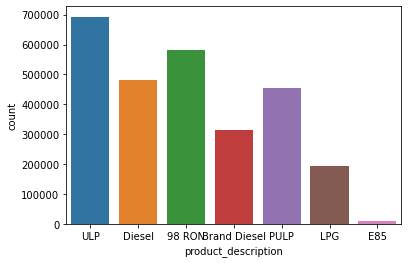

In [52]:
# Quick plot of the diffrent products 
sns.countplot("product_description", data = perth_fuel )

In [54]:
# reset  the index before we move to plit the dates. 
perth_fuel = perth_fuel.reset_index()

# Create for loop to split the data frame into year, month, day 
# this way you can also add day names. 
for col in ['publish_date']:
    date_col = pd.to_datetime(perth_fuel[col])
    # perth_fuel[col + '_weekday'] = date_col.dt.day_name()
    perth_fuel[col + '_day'] = date_col.dt.day
    perth_fuel[col + '_month'] = date_col.dt.month
    perth_fuel[col + '_year'] = date_col.dt.year
    
    del perth_fuel[col]


In [ ]:
# Due to the size of the dataset going to narrow the scope down to ULP prices only. 
# Create dict to store the ref
fuel_type = ['ULP']

# Action using loc and drop the product and region. 
perth_fuel = perth_fuel.loc[perth_fuel[
    'product_description'].isin(fuel_type)].drop(columns=[
        'product_description', 'region_description'])

In [57]:
# Wanted to see correlation 
corr = perth_fuel.corr()
corr.style.background_gradient(cmap='coolwarm')

,index,product_price,publish_date_day,publish_date_month,publish_date_year
index,1.000000,0.048498,0.051351,0.145435,0.942533
product_price,0.048498,1.000000,0.017941,0.052547,0.011638
publish_date_day,0.051351,0.017941,1.000000,-0.022798,-0.025258
publish_date_month,0.145435,0.052547,-0.022798,1.000000,-0.057669
publish_date_year,0.942533,0.011638,-0.025258,-0.057669,1.000000


In [179]:
# Time to dive up the data into x and y 
X_df = perth_fuel.drop(columns=['index','product_price'])
y = perth_fuel['product_price'].values

In [180]:
# split into train and test for both x and y 
X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=197
)

# print to see the shape of each. 
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(554332, 3)
(138584, 3)
(554332,)
(138584,)


Model 1 Linear Regression 
Model 2 Linear LinearSVR
Model 3 Linear LGBMRegressor

In [181]:
def build_evaluate_fn(X_train, y_train, X_test, y_test):
    def evaluate(model):
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)

        print("Train Score:", train_score)
        print("Test Score:", test_score)
        print()
        
        compute_mse(model, X_train, y_train, 'training set')
        compute_mse(model, X_test, y_test, 'test set')
    
    return evaluate

evaluate = build_evaluate_fn(X_train, y_train, X_test, y_test)

In [182]:
# linear 
# Define the model. 
model = LinearRegression()
# Fir the model to the train data. 
model.fit(X_train, y_train)
# Get some predictions 
y_liner = model.predict(X_test)
# Get a evaluation of the model. 
evaluate(model)

Train Score: 0.003298101455164959
Test Score: 0.003596915033935

Mean Squared Error for training set: 341.64701731031835
Mean Squared Error for test set: 340.06407443840635


In [183]:
# Linear SVR 
# Define the model. 
svm = LinearSVR()
# Fit the model to the train data. 
svm.fit(X_train, y_train)
# Get some prediction. 
y_svm = svm.predict(X_test)
# See how she did. 
evaluate(svm)

Train Score: 0.001354521999779812
Test Score: 0.0015997673595691264

Mean Squared Error for training set: 342.3132326800366
Mean Squared Error for test set: 340.74568430658854


In [184]:
# Linear Regressor 
# define the model and n estmatores 
gbr = LGBMRegressor(n_estimators=1000)
# Fit the train data. 
gbr.fit(X_train, y_train)
# get some predictions. 
y_gbr = gbr.predict(X_test)
# How good was the model check ??? 
evaluate(gbr)

Train Score: 0.6837293946536747
Test Score: 0.6836829830775832

Mean Squared Error for training set: 108.41045766768978
Mean Squared Error for test set: 107.95636345556164


Model 4 RandomForestRegressor

In [185]:
# call sklearn standardscaler 
from sklearn.preprocessing import StandardScaler
# tell the scaler mean = false. 
sc = StandardScaler(with_mean=False)
# tranform the x train and x test. 
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [186]:
# call sklearn model.
from sklearn.ensemble import RandomForestRegressor
# Set the n estimators 500. 
regressor = RandomForestRegressor(n_estimators=500, random_state=0)
# fit the train data to the model 
regressor.fit(X_train, y_train)
# get some predctions. 
y_regges = regressor.predict(X_test)

In [187]:
# Check model perf
evaluate(regressor)

Train Score: -0.45788511782113095
Test Score: -0.45786283413837103

Mean Squared Error for training set: 499.7302631929179
Mean Squared Error for test set: 497.55644360163905


In [201]:
# Grab all the data into a dataframe. 
predictions = pd.DataFrame({'Actual': y_test,'LineearReg': y_liner,'LGBMRegressor':y_gbr,'LinearSVR': y_svm, 'RandomForestRegressor': y_regges})
predictions

,Actual,LineearReg,LGBMRegressor,LinearSVR,RandomForestRegressor
0,125.9,136.708178,129.516196,135.918208,129.608344
1,139.3,134.565949,142.312275,134.114518,142.329934
2,159.9,137.544522,148.200638,136.483892,148.260678
3,155.7,137.614365,159.843549,136.525210,160.169924
4,160.9,137.821910,148.506935,137.269002,148.483170
...,...,...,...,...,...
138579,169.9,137.453746,170.093848,136.378472,170.227033
138580,152.8,135.212121,153.985927,134.173151,154.085692
138581,113.9,135.362274,118.301553,134.287838,118.306675
138582,155.9,135.370892,145.844785,134.584049,146.004528


In [199]:
predictions.dtypes

Actual                   float64
LineearReg               float64
LGBMRegressor            float64
LinearSVR                float64
RandomForestRegressor    float64
dtype: object

In [200]:
predictions.to_csv('ml.csv')

In [189]:
from sklearn.preprocessing import StandardScaler

test = sc.inverse_transform(X_test)

In [190]:
test2 = pd.DataFrame(test,columns=['day', 'month', 'year'])

In [191]:
test2

,day,month,year
0,16.0,7.0,2020.0
1,8.0,2.0,2019.0
2,6.0,10.0,2021.0
3,15.0,9.0,2021.0
4,31.0,10.0,2019.0
...,...,...,...
138579,11.0,9.0,2021.0
138580,6.0,2.0,2021.0
138581,17.0,1.0,2021.0
138582,19.0,2.0,2020.0


In [193]:
test2['day'] = test2['day'].astype(str).apply(lambda x: x.replace('.0',''))
test2['month'] = test2['month'].astype(str).apply(lambda x: x.replace('.0',''))
test2['year'] = test2['year'].astype(str).apply(lambda x: x.replace('.0',''))

In [196]:
example = pd.concat([test2, predictions], axis=1, join="inner")

In [197]:
example.to_csv('example.csv')